# Deep Learning-Based Hybrid Recommendation System (with enriched content for users and movies)

## Introduction

As recommendation systems evolve, **deep learning** has emerged as a powerful tool to enhance predictions by combining collaborative filtering (CF) and content-based filtering (CBF). Traditional methods like **matrix factorization** and **similarity-based approaches** are effective but often fail to capture complex, non-linear relationships between users, items, and additional features. By leveraging deep neural networks, we can design flexible models capable of learning richer representations for users and items while incorporating metadata.

This notebook will introduce **Neural Collaborative Filtering (NCF)** and a **deep hybrid model** that combines user-item interaction data with item and user content features. These methods aim to improve prediction accuracy, particularly in sparse datasets, while addressing cold-start problems.

---

## Key Concepts

### 1. **Embeddings**
Embeddings are **dense vector representations** of discrete variables like users or items. Instead of using one-hot vectors, embeddings project users and items into a continuous latent space, capturing similarities based on interaction history.

- **User Embeddings**: Learn latent preferences of users.
- **Item Embeddings**: Capture latent characteristics of items.

Embeddings are trainable and updated during the training process, similar to weights in a neural network.

---

### 2. **Neural Collaborative Filtering (NCF)**

Neural Collaborative Filtering extends matrix factorization by replacing the linear dot product with a **neural network** that models complex interactions between users and items. Key components include:

- **Embedding Layers**: Represent users and items as embeddings.
- **Concatenation**: Combine user and item embeddings to create a feature vector.
- **Multi-Layer Perceptron (MLP)**: A feedforward neural network processes the concatenated embeddings to predict user-item interaction scores.

---

### 3. **Hybrid Models: Combining CF and Content Features**

To address the cold-start problem and sparse data limitations of CF, we can incorporate **item metadata** (e.g., genre, description) and **user attributes** into the model:

- **Collaborative Features**: Learned embeddings from user-item interaction data.
- **Content-Based Features**: Preprocessed metadata, such as TF-IDF vectors or numerical attributes, fed as input to the neural network.

The **deep hybrid model** concatenates these two feature sets, allowing the network to learn from both collaborative and content-based information.

In this notebook I realized that I have created a recommendation model for a fixed amount of users. The embeddings depend on the number of users in the nets architecture. Here is some more info about that kind of recommendation systems:

### **Fixed user dimensions: When Was It Used in Real Life?**

1. **Early Collaborative Filtering Systems**:
   - Early systems like **Matrix Factorization (e.g., SVD)** rely on fixed user and item embedding dimensions.
   - These systems work well in environments where:
     - The user base and catalog are relatively static.
     - Retraining can be done frequently enough to include new users/items.

2. **Small-Scale Systems**:
   - In applications with a stable number of users/items (e.g., internal company systems or niche platforms), fixed embeddings might still be practical.

3. **Static Datasets**:
   - In benchmarks like **MovieLens**, the user/item base is fixed, so this approach is used for simplicity in academic research.

---

#### **Challenges in Real-Life Applications**

1. **Dynamic User/Item Bases**:
   - Real-world systems often see frequent additions of new users and items (e.g., e-commerce, streaming platforms).
   - Fixed embedding tables require retraining to accommodate new users or items, which can be computationally expensive and infeasible at scale.

2. **Cold-Start Problems**:
   - Fixed embeddings do not handle cold-start scenarios well because new users/items lack pre-trained embeddings.

3. **Scalability**:
   - As the number of users/items grows, embedding tables become larger, increasing memory usage and computational costs.

4. **Sparse Data**:
   - Many real-world datasets are sparse, meaning many users interact with only a small subset of items.
   - Fixed embedding sizes don’t inherently address sparsity.

---

#### **Real-Life Alternatives to Fixed Dimension Approaches**

1. **Feature-Based Representations (Content-Driven)**:
   - Instead of tying the model to fixed user/item IDs, use **feature vectors** derived from metadata (e.g., age, genre, description embeddings).
   - **Example**: Streaming platforms like Netflix use **content-based features** to handle new users or items.

2. **Hybrid Systems**:
   - Combine fixed embeddings for frequent users/items with content-based embeddings for new users/items.
   - **Example**: Amazon combines user interaction history with item content features to improve personalization.

3. **Dynamic Embedding Models**:
   - Models like **Deep Factorization Machines (DeepFM)** and **Wide & Deep Networks** generate embeddings dynamically based on input features, making them adaptable to changing datasets.

4. **Meta-Learning for Cold Start**:
   - Meta-learning approaches like **MAML (Model-Agnostic Meta-Learning)** train the model to generalize well to new users/items with minimal fine-tuning.

5. **Continuous Learning**:
   - Incremental learning models update embeddings as new data arrives without retraining the entire network.
   - **Example**: Google’s recommendation systems often use real-time updates to embeddings.

---

#### **Examples of Real-Life Systems**

1. **Netflix**:
   - Initially used Matrix Factorization (a fixed dimension approach) during the Netflix Prize.
   - Transitioned to a hybrid system combining collaborative filtering and content-based approaches.

2. **Amazon**:
   - Uses a mix of collaborative filtering and item-based recommendations augmented with dynamic content-based features.

3. **Spotify**:
   - Uses user and item embeddings enriched with audio features, user preferences, and metadata.

4. **YouTube**:
   - Combines user interaction embeddings with video metadata for recommendations.

---

#### **Conclusion**

The fixed-dimension approach has been used historically, especially in systems with static datasets or user bases. However, in modern, dynamic environments, it is considered inflexible. Most real-life systems now adopt **feature-based representations**, **hybrid models**, or **incremental learning** to handle dynamic user/item bases and cold-start scenarios effectively.


---


## Workflow for Building a Deep Hybrid Model

1. **Data Preparation**:
   - Preprocess user-item interaction data (e.g., rating matrix).
   - Extract and preprocess item content features (e.g., TF-IDF for text, numerical metadata).

2. **Neural Collaborative Filtering (NCF)**:
   - Design embedding layers for users and items.
   - Train a basic NCF model using user-item interactions.

3. **Incorporating Content-Based Features**:
   - Merge item metadata or user features with embeddings.
   - Pass the combined features through an MLP for final predictions.

4. **Evaluation**:
   - Use metrics like RMSE, Precision@K, or Hit Ratio to evaluate the model's performance.

---

## Objective of This Notebook

ToDo

---

# Prepare data

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from codebase.prep_data import ContentFeatureEngineeringUsingSBERT, DataManager, UserFeatureEngineeringUsingSBERT, MovieLensDataset, split_data_by_user, inspect_dictionary
import sys

from torch.utils.tensorboard import SummaryWriter
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
RATINGS_PATH = 'data/ml-latest-small/ratings.csv'
MOVIES_ENRICHED_PATH = 'data/ml-latest-small/movies_enriched.csv'
USER_ENRICHED_PATH = 'data/ml-latest-small/users_enriched.csv'
TAGS_PATH = 'data/ml-latest-small/tags.csv'
BATCH_SIZE = 128
CONTENT_DIM = 768

# Paths for saved embeddings
ITEM_EMBEDDINGS_PATH = "data/ml-latest-small/item_embeddings.npy"
ITEM_MAPPING_PATH = "data/ml-latest-small/item_mapping.npy"
USER_EMBEDDINGS_PATH = "data/ml-latest-small/user_embeddings.npy"
USER_MAPPING_PATH = "data/ml-latest-small/user_mapping.npy"

# Step 1: Load ratings
data_manager = DataManager(RATINGS_PATH)
ratings = data_manager.load_ratings()
tags = pd.read_csv(TAGS_PATH)

# Encode user-item interactions
ratings = data_manager.encode_interactions(ratings)
n_users, n_items = data_manager.get_user_item_count(ratings)
print(f"\nNumber of unique users: {n_users}, Number of unique items: {n_items}")

# Step 2: Prepare item content features
valid_movie_ids = ratings['movieId'].unique()
feature_engineer = ContentFeatureEngineeringUsingSBERT(MOVIES_ENRICHED_PATH, data_manager.item_encoder, device)

# Load or create item embeddings
if os.path.exists(ITEM_EMBEDDINGS_PATH) and os.path.exists(ITEM_MAPPING_PATH):
    # we need this for later
    movies_enriched = feature_engineer.load_enriched_movies(valid_movie_ids)
    movies_enriched = feature_engineer.prepare_combined_features(movies_enriched)

    item_content_features = np.load(ITEM_EMBEDDINGS_PATH)
    movie_ids = np.load(ITEM_MAPPING_PATH)
    movie_id_to_content = {movie_id: embedding for movie_id, embedding in zip(movie_ids, item_content_features)}
    print("Item embeddings loaded.")
else:
    movies_enriched = feature_engineer.load_enriched_movies(valid_movie_ids)
    movies_enriched = feature_engineer.prepare_combined_features(movies_enriched)
    movie_id_to_content, item_content_features = feature_engineer.create_content_features(movies_enriched)
    np.save(ITEM_EMBEDDINGS_PATH, item_content_features)
    np.save(ITEM_MAPPING_PATH, np.array(list(movie_id_to_content.keys())))
    print("Item embeddings calculated and saved.")

print("\nSample Movie Features:")
inspect_dictionary(movie_id_to_content)

print("\nSample Combined Item Features (Transformer Embeddings):")
print(pd.DataFrame(item_content_features[:5]).head())

# Step 3: Prepare user content features
valid_user_ids = ratings['userId'].unique()  # Get userIds from ratings
user_feature_engineer = UserFeatureEngineeringUsingSBERT(USER_ENRICHED_PATH, data_manager.user_encoder, device)

# Load or create user embeddings
if os.path.exists(USER_EMBEDDINGS_PATH) and os.path.exists(USER_MAPPING_PATH):
    # we need this for later
    users_enriched = user_feature_engineer.load_enriched_users(valid_user_ids)
    users_enriched = user_feature_engineer.prepare_combined_features(users_enriched)

    user_content_features = np.load(USER_EMBEDDINGS_PATH)
    user_ids = np.load(USER_MAPPING_PATH)
    user_id_to_content = {user_id: embedding for user_id, embedding in zip(user_ids, user_content_features)}
    print("User embeddings loaded.")
else:
    users_enriched = user_feature_engineer.load_enriched_users(valid_user_ids)
    users_enriched = user_feature_engineer.prepare_combined_features(users_enriched)
    user_id_to_content, user_content_features = user_feature_engineer.create_user_features(users_enriched)
    np.save(USER_EMBEDDINGS_PATH, user_content_features)
    np.save(USER_MAPPING_PATH, np.array(list(user_id_to_content.keys())))
    print("User embeddings calculated and saved.")

print("\nSample User Features:")
inspect_dictionary(user_id_to_content)

print("\nSample Combined User Features (Transformer Embeddings):")
print(pd.DataFrame(user_content_features[:5]).head())

# Step 4: Split data by user
train_data, val_data, test_data = split_data_by_user(ratings)
print(f"\nUser-Level Split: Train = {len(train_data)}, Validation = {len(val_data)}, Test = {len(test_data)}")

# Step 5: Create datasets and dataloaders
train_dataset = MovieLensDataset(train_data, user_id_to_content, movie_id_to_content)
val_dataset = MovieLensDataset(val_data, user_id_to_content, movie_id_to_content)
test_dataset = MovieLensDataset(test_data, user_id_to_content, movie_id_to_content)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8)

print("\nData Preparation Complete. Dataloaders Ready!")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")



Number of unique users: 610, Number of unique items: 9724
Item embeddings loaded.

Sample Movie Features:
Type: <class 'dict'>

First 5 keys:
[0, 1, 2, 3, 4]

First 5 values (shapes and examples):
Key: 0, Value Shape: (768,), Value Sample: [ 0.06085226  0.05872172 -0.01586064 -0.03862809  0.01193655]
Key: 1, Value Shape: (768,), Value Sample: [ 0.08129846  0.01215789 -0.00998183 -0.0026806   0.01916343]
Key: 2, Value Shape: (768,), Value Sample: [ 0.07269978  0.03968232  0.01705796 -0.03007039  0.01678096]
Key: 3, Value Shape: (768,), Value Sample: [ 0.06406538  0.00694661 -0.00816733 -0.02460494 -0.01866039]
Key: 4, Value Shape: (768,), Value Sample: [ 0.03503072  0.0034123  -0.00281779 -0.03417671 -0.06114816]

Sample Combined Item Features (Transformer Embeddings):
        0         1         2         3         4         5         6    \
0  0.060852  0.058722 -0.015861 -0.038628  0.011937  0.013824  0.015017   
1  0.081298  0.012158 -0.009982 -0.002681  0.019163 -0.008715 -0.03231

Let's save the embeddings so we not need to recreate them again and again.

In [2]:
import numpy as np

# Save item embeddings and mapping
item_embeddings_path = "data/ml-latest-small/item_embeddings.npy"
item_mapping_path = "data/ml-latest-small/item_mapping.npy"

np.save(item_embeddings_path, item_content_features)
np.save(item_mapping_path, np.array(list(movie_id_to_content.keys())))

print(f"Item embeddings saved to {item_embeddings_path}")
print(f"Item mapping saved to {item_mapping_path}")

# Save user embeddings and mapping
user_embeddings_path = "data/ml-latest-small/user_embeddings.npy"
user_mapping_path = "data/ml-latest-small/user_mapping.npy"

np.save(user_embeddings_path, user_content_features)
np.save(user_mapping_path, np.array(list(user_id_to_content.keys())))

print(f"User embeddings saved to {user_embeddings_path}")
print(f"User mapping saved to {user_mapping_path}")

Item embeddings saved to data/ml-latest-small/item_embeddings.npy
Item mapping saved to data/ml-latest-small/item_mapping.npy
User embeddings saved to data/ml-latest-small/user_embeddings.npy
User mapping saved to data/ml-latest-small/user_mapping.npy


Let's check the embeddings in the data loaders.

In [2]:
# Function to check the first n items of a batch (including user and item embeddings)
def inspect_batch(test_loader, user_id_to_content, movie_id_to_content, n=5):
    # Get one batch from the test_loader
    for batch_idx, (user_indices, item_indices, user_content_features, item_content_features, ratings) in enumerate(test_loader):
        print(f"Inspecting Batch {batch_idx + 1}")
        
        # Print the first n items in the batch
        for i in range(min(n, len(user_indices))):  # Ensure we don't exceed batch size
            user_id = user_indices[i].item()
            movie_id = item_indices[i].item()
            
            print(f"\nItem {i + 1}:")
            print(f"  User Index: {user_id}")
            print(f"  User Embedding (First 5 Dimensions): {user_content_features[i][:5].tolist()}")
            print(f"  User Embedding from Dictionary (First 5 Dimensions): {user_id_to_content[user_id][:5].tolist()}")
            print(f"  Item Index (Encoded Movie ID): {movie_id}")
            print(f"  Item Embedding (First 5 Dimensions): {item_content_features[i][:5].tolist()}")
            print(f"  Item Embedding from Dictionary (First 5 Dimensions): {movie_id_to_content[movie_id][:5].tolist()}")
            print(f"  Rating: {ratings[i].item()}")
        
        # Only inspect the first batch
        break

# Inspect the first batch of test_loader
inspect_batch(test_loader, user_id_to_content, movie_id_to_content, n=5)

# Function to validate embeddings (both user and item embeddings)
def validate_embeddings(test_loader, user_id_to_content, movie_id_to_content, n=5):
    for batch_idx, (user_indices, item_indices, user_content_features, item_content_features, ratings) in enumerate(test_loader):
        print(f"Validating Batch {batch_idx + 1}")
        
        for i in range(min(n, len(user_indices))):
            user_id = user_indices[i].item()
            movie_id = item_indices[i].item()
            
            # Validate user embedding
            embedding_from_user_dataloader = user_content_features[i].tolist()
            embedding_from_user_dict = user_id_to_content[user_id]
            assert np.allclose(embedding_from_user_dataloader, embedding_from_user_dict), \
                f"Mismatch for User ID: {user_id}"
            print(f"User ID {user_id}: Embedding matches!")
            
            # Validate movie embedding
            embedding_from_movie_dataloader = item_content_features[i].tolist()
            embedding_from_movie_dict = movie_id_to_content[movie_id]
            assert np.allclose(embedding_from_movie_dataloader, embedding_from_movie_dict), \
                f"Mismatch for Movie ID: {movie_id}"
            print(f"Movie ID {movie_id}: Embedding matches!")
        
        # Only validate the first batch
        break

# Validate the embeddings for both users and items
validate_embeddings(test_loader, user_id_to_content, movie_id_to_content, n=50)

Inspecting Batch 1

Item 1:
  User Index: 0
  User Embedding (First 5 Dimensions): [0.06323417276144028, 0.05469479411840439, -0.011203102767467499, 0.010495969094336033, -0.006903305184096098]
  User Embedding from Dictionary (First 5 Dimensions): [0.06323417276144028, 0.05469479411840439, -0.011203102767467499, 0.010495969094336033, -0.006903305184096098]
  Item Index (Encoded Movie ID): 2523
  Item Embedding (First 5 Dimensions): [0.059084683656692505, 0.058120932430028915, 0.02137676067650318, 0.019144346937537193, -0.05452856048941612]
  Item Embedding from Dictionary (First 5 Dimensions): [0.059084683656692505, 0.058120932430028915, 0.02137676067650318, 0.019144346937537193, -0.05452856048941612]
  Rating: 5.0

Item 2:
  User Index: 0
  User Embedding (First 5 Dimensions): [0.06323417276144028, 0.05469479411840439, -0.011203102767467499, 0.010495969094336033, -0.006903305184096098]
  User Embedding from Dictionary (First 5 Dimensions): [0.06323417276144028, 0.05469479411840439, -

Let's test the distribution of the users in our datasets. Ideally they should be **equally** distributed.

Number of unique users:
Train: 610
Val:   610
Test:  610

Overlap between datasets:
Users in all three (Train, Val, Test): 610
Users only in Train: 0
Users only in Val: 0
Users only in Test: 0
Users in Train & Val but not Test: 0
Users in Train & Test but not Val: 0
Users in Val & Test but not Train: 0

Average number of ratings per user:
Train: 115.2655737704918
Val:   24.757377049180327
Test:  25.281967213114754


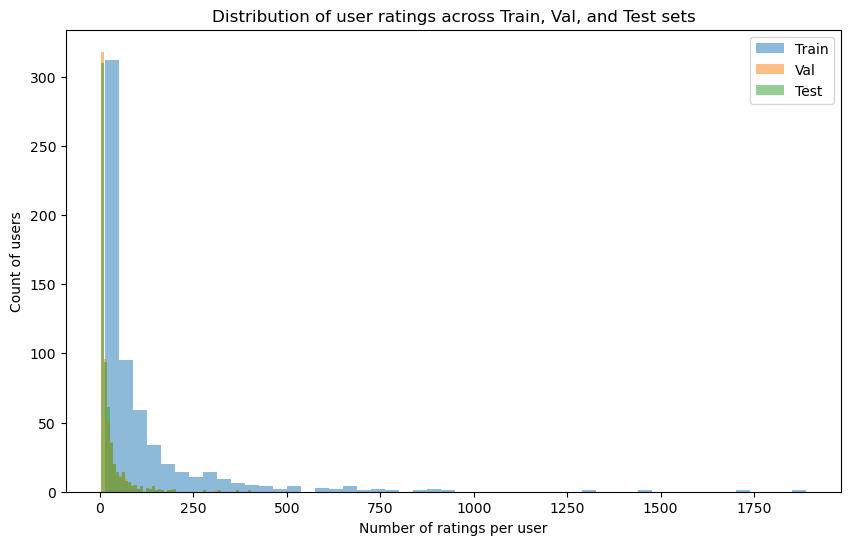

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have train_data, val_data, and test_data as DataFrames from your preparation step

# Number of unique users in each dataset
print("Number of unique users:")
print("Train:", train_data['user_id'].nunique())
print("Val:  ", val_data['user_id'].nunique())
print("Test: ", test_data['user_id'].nunique())

# Get sets of users for each dataset
train_users = set(train_data['user_id'].unique())
val_users = set(val_data['user_id'].unique())
test_users = set(test_data['user_id'].unique())

# Check overlaps
print("\nOverlap between datasets:")
print("Users in all three (Train, Val, Test):", len(train_users & val_users & test_users))
print("Users only in Train:", len(train_users - val_users - test_users))
print("Users only in Val:", len(val_users - train_users - test_users))
print("Users only in Test:", len(test_users - train_users - val_users))

# Check two-set overlaps
print("Users in Train & Val but not Test:", len((train_users & val_users) - test_users))
print("Users in Train & Test but not Val:", len((train_users & test_users) - val_users))
print("Users in Val & Test but not Train:", len((val_users & test_users) - train_users))

# Compute number of ratings per user in each dataset
user_train_counts = train_data['user_id'].value_counts()
user_val_counts = val_data['user_id'].value_counts()
user_test_counts = test_data['user_id'].value_counts()

print("\nAverage number of ratings per user:")
print("Train:", user_train_counts.mean())
print("Val:  ", user_val_counts.mean())
print("Test: ", user_test_counts.mean())

# Optionally, visualize the distribution of ratings per user
plt.figure(figsize=(10,6))
plt.hist(user_train_counts, bins=50, alpha=0.5, label='Train')
plt.hist(user_val_counts, bins=50, alpha=0.5, label='Val')
plt.hist(user_test_counts, bins=50, alpha=0.5, label='Test')
plt.xlabel("Number of ratings per user")
plt.ylabel("Count of users")
plt.title("Distribution of user ratings across Train, Val, and Test sets")
plt.legend()
plt.show()


## Code Explanation: Data Preparation for Deep Hybrid Recommendation System

ToDo: Fill out section.

## But what is with the unrated movies that have been excluded in the content matrix (because they have no ratings)?

### 1. Why Include Unrated Movies?

In a typical recommendation system, **unrated movies** (i.e., movies with no user ratings) are often ignored because collaborative filtering (CF) relies on user-item interactions. However, excluding these movies leads to:

1. **Cold-Start Problem**: New or unseen movies cannot be recommended because they lack historical ratings.
2. **Loss of Content Information**: Movies often have meaningful **content features** (e.g., genres, tags) that can still provide recommendations.

By including unrated movies, we ensure that the system is capable of **exploring new content** and delivering diverse recommendations.

---

### 2. Content-Based Approach for Unrated Movies

#### How it Works:
For unrated movies, recommendations rely on **content similarity** rather than collaborative filtering:
- **Content Features**: Tags, genres, or textual metadata are processed (e.g., using TF-IDF) to form feature vectors.
- **Similarity**: Unrated movies are compared to rated movies using **cosine similarity** or other similarity metrics.
- **Recommendation**: Movies with the highest content similarity to the user's watched/rated movies are recommended.

#### Key Points:
1. **No Learning Required**: Content-based recommendations for unrated movies require no model training.
2. **Similarity-Based**: Recommendations are purely based on similarity between content features.
3. **Independent of Ratings**: Unrated movies are handled differently from rated movies because there is no user-item interaction.

---

### 3. Combining Rated and Unrated Movies

To unify recommendations for both rated and unrated movies, we can combine:
1. **Collaborative Filtering Predictions**: Predict ratings for rated movies using user-item interaction learning (e.g., matrix factorization).
2. **Content Similarity Scores**: Compute similarity-based scores for unrated movies using content features.

#### Combined Score Formula:
The final score for each movie is calculated as:

$$
\text{Final Score} = \alpha \times \text{CF Prediction} + (1 - \alpha) \times \text{Content Similarity}
$$

Where:
- **CF Prediction**: Predicted ratings from collaborative filtering.
- **Content Similarity**: Similarity score based on content features.
- **\alpha**: Weight factor (e.g., 0.7 for collaborative filtering, 0.3 for content similarity).

#### Steps to Handle Combined Recommendations:
1. Compute predicted ratings for all movies (including unrated ones).
2. For movies with no user interactions:
   - Use their content similarity score instead of collaborative filtering predictions.
3. Rank all movies based on the combined score.
4. Exclude movies already rated by the user.

---

### 4. Handling Unrated Movies from a User's Perspective

From the perspective of a user, unrated movies can be seen as:

1. **"You Might Also Like" Suggestions**:
   - These are recommendations based on content features (e.g., genres or tags) similar to movies the user has already interacted with.

2. **Cold-Start Recommendations**:
   - For new movies with no ratings, the system can still recommend them based on their **content similarity**.

3. **Exploration Opportunities**:
   - Unrated movies help users discover new content, encouraging exploration beyond their typical preferences.

4. **Fallback for Sparse Users**:
   - For users with very few ratings, content-based recommendations ensure the system can still provide meaningful suggestions.

#### Comparison Between Rated and Unrated Movies:

| Aspect                         | Rated Movies                        | Unrated Movies                      |
|--------------------------------|------------------------------------|------------------------------------|
| **Source of Recommendation**   | Collaborative Filtering (CF)       | Content-Based Filtering (Similarity)|
| **Dependency**                 | Requires historical user ratings   | Relies only on content features     |
| **Learning Requirement**       | Requires model training            | No learning required                |
| **Cold-Start Capability**      | Not effective for new items        | Effective for new or unseen items   |
| **Diversity**                  | Often biased by user preferences   | Promotes content-driven exploration |

---

### 5. Benefits of Including Unrated Movies

- **Cold-Start Problem Solved**: New movies can still be recommended based on their content features.
- **Increased Coverage**: The system considers all available movies, not just those with ratings.
- **Diverse Recommendations**: Content-based methods ensure users are exposed to new and relevant content.

By combining collaborative filtering and content-based approaches, we create a unified system capable of handling both rated and unrated movies effectively.

---

### Conclusion

Unrated movies are recommended based on **content similarity** rather than user interactions. By combining collaborative filtering predictions for rated movies and content-based scores for unrated movies, we ensure a robust, unified recommendation system that improves coverage, diversity, and user satisfaction.



## ToDo: Handle the unrated movies

# Implement Neural Collaborative Filtering (NCF)

Neural Collaborative Filtering (NCF) is a deep learning-based approach to collaborative filtering that replaces the traditional matrix factorization with a neural network to model user-item interactions. The steps to implement NCF in PyTorch are as follows:

---

## **1. Define the Problem**
- **Objective**: Predict user-item interactions (ratings or implicit feedback) using a neural network.
- **Inputs**:
  - **User Embeddings**: Encoded representations for users.
  - **Item Embeddings**: Encoded representations for items.
  - **Optional**: Item content features (e.g., genres, tags) can be integrated later for a hybrid model.
- **Output**: A predicted interaction score (e.g., a rating or a probability of interaction).

---

## **2. Prepare the Data**
- Data is already prepared from the previous steps:
  - User and item indices are encoded using `LabelEncoder`.
  - Train, validation, and test splits have been created using temporal ordering.
  - Item content features (TF-IDF vectors) are available for future hybridization.
- Dataloaders for train, validation, and test datasets are ready.

---

## **3. Build the NCF Model**
Design the Neural Collaborative Filtering architecture. The model will include:
1. **Embedding Layers**:
   - Learn low-dimensional dense representations for users and items.
2. **Concatenation**:
   - Combine the user and item embeddings to form the input to the neural network.
3. **Fully Connected Layers**:
   - Pass the concatenated embeddings through multiple dense (linear) layers.
   - Use activation functions (e.g., ReLU) between layers.
4. **Output Layer**:
   - Predict a single score (e.g., a rating) with a suitable activation function:
     - **Regression Task** (e.g., predicting ratings): Linear output.
     - **Binary Classification** (e.g., implicit feedback): Sigmoid activation for probability.

---

## **4. Train the NCF Model**
- Define a loss function:
  - **Mean Squared Error (MSE)** for regression tasks.
  - **Binary Cross-Entropy Loss** for implicit feedback.
- Choose an optimizer (e.g., Adam).
- Use backpropagation to update the model parameters.
- Train the model for a specified number of epochs and evaluate on the validation set.

---

## **5. Evaluate the Model**
- Use evaluation metrics suitable for the problem type:
  - **Regression**:
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
  - **Ranking/Implicit Feedback**:
    - Precision@K
    - Recall@K
    - NDCG (Normalized Discounted Cumulative Gain)

---

## **6. Predict and Recommend**
- For each user, generate predictions for all unrated movies.
- Rank the predictions to recommend the top-N movies.
- Combine this with content-based filtering scores later to improve diversity and handle cold-start issues.

---

## **Summary of the Steps**
1. Define the problem and clarify inputs/outputs.
2. Prepare the data (user indices, item indices, content features).
3. Build the NCF model with embedding layers, fully connected layers, and an output layer.
4. Train the model using appropriate loss functions and optimizers.
5. Evaluate the model using metrics like RMSE, Precision@K, or Recall@K.
6. Generate predictions for unrated items and recommend the top-N items for each user.

---

With these steps, we will implement NCF as the next part of our recommendation system pipeline in PyTorch. 🚀


## Understanding Embeddings in NCF: Why Are User and Item Embeddings Needed?

In Neural Collaborative Filtering (NCF), **embeddings** for users and items play a crucial role in transforming **discrete indices** into **learnable representations** that capture relationships and patterns. Here's why embeddings are essential and what they add to the network:

---

### 1. **What Are Embeddings?**
- An **embedding** is a low-dimensional, dense vector representation of a categorical variable (e.g., users or items).
- In NCF:
  - Each **user** index is mapped to a unique embedding vector.
  - Each **item** index is mapped to a unique embedding vector.

Example:
- Suppose we have 3 users (`[0, 1, 2]`) and 3 items (`[0, 1, 2]`).
- If the embedding dimension is 2:
  - Users are represented as:  
    `User 0 → [0.1, 0.3]`, `User 1 → [0.5, 0.7]`, `User 2 → [0.9, 0.2]`
  - Items are represented as:  
    `Item 0 → [0.4, 0.6]`, `Item 1 → [0.8, 0.5]`, `Item 2 → [0.2, 0.9]`

These embeddings are **learned** during training, meaning their values adjust to minimize the prediction error.

---

### 2. **Why Are Embeddings Used?**

#### (a) **Representing High-Dimensional Categorical Data**
- User and item IDs are **discrete indices** (e.g., `User 0`, `Item 1`), which have no inherent numerical meaning.
- Embeddings transform these indices into **dense vectors** in a continuous space, where:
  - Users with similar behaviors will have similar embedding vectors.
  - Items with similar characteristics will have similar embedding vectors.

#### (b) **Capturing Latent Features**
- Embeddings act as **feature extractors**:
  - For users: Embeddings learn **latent preferences** of the users.
  - For items: Embeddings learn **latent characteristics** of the items.
- These features are not explicitly provided in the data but are **automatically learned** by the network.

Example:
- A user's embedding might represent that they prefer "action" and "sci-fi" movies.
- An item's embedding might represent that it is categorized as "action" and has "high ratings."

---

### 3. **What Do Embeddings Add to the Network?**

#### (a) **Enable the Network to Generalize**
- By learning embeddings, the NCF network generalizes user-item interactions beyond the raw indices.
- Users and items with **similar embeddings** will behave similarly in the network's predictions.

For example:
- If `User A` has preferences similar to `User B`, their embeddings will be close in the latent space.
- The model will predict similar ratings for items rated by `User B` when recommending to `User A`.

#### (b) **Reduce Input Dimensionality**
- Instead of using one-hot encoding (which would create huge sparse vectors for users and items), embeddings reduce the input to **low-dimensional dense vectors**.
- This makes training more efficient and computationally feasible.

For example:
- One-hot encoding for 1 million users would create a vector of size 1,000,000.
- Using embeddings of dimension 32 reduces it to a **32-dimensional dense vector**.

#### (c) **Capture Complex User-Item Interactions**
- Embeddings provide a numerical basis to model **relationships** between users and items.
- By concatenating the user and item embeddings, the network can learn non-linear interactions through its fully connected layers.

---

### 4. **How Are Embeddings Learned?**
- Embedding values are initialized randomly at the start of training.
- During training, embeddings are updated using **backpropagation** to minimize the prediction loss.
- Over time, embeddings adjust to capture user preferences and item characteristics that lead to accurate predictions.

---

### 5. **Summary: What Do Embeddings Add?**

| **Purpose**                    | **Explanation**                                                   |
|--------------------------------|-------------------------------------------------------------------|
| **Feature Representation**     | Converts indices to dense vectors that represent latent features. |
| **Dimensionality Reduction**   | Replaces large sparse one-hot vectors with small dense embeddings.|
| **Generalization**             | Allows the model to identify similarities between users and items.|
| **Efficient Training**         | Enables the model to learn patterns in user-item interactions.   |
| **Capture Relationships**      | Encodes complex relationships between users and items.           |

---

### Example:
Imagine predicting movie ratings for `User 0` and `Item 0`:
1. User 0 → Embedding `[0.1, 0.3]`
2. Item 0 → Embedding `[0.4, 0.6]`
3. Combine these embeddings and pass them through the network:
   - Output: Predicted Rating = 4.2

The embeddings allow the model to **learn patterns** that map user-item pairs to predicted ratings, even if the exact pair has not been seen before.



## Information Encoded in User-Item Embeddings

When the only available data consists of **user IDs**, **item IDs**, and their **ratings**, the embeddings in a Neural Collaborative Filtering (NCF) model capture specific patterns that reflect the **relationship between users and items**. Below, we explore the types of information that can be encoded with this minimal setup.

---

### 1. **Latent Features of Users and Items**

#### What Are Latent Features?
Latent features are **hidden characteristics** of users and items that are **inferred indirectly** from the data. These features are not explicitly provided but are learned based on user-item interactions (ratings).

#### Examples of Latent Features:
- For Users:
  - Preferences for specific genres or categories (e.g., "likes action movies").
  - General tendencies, such as rating items highly or conservatively.
  - Hidden group affiliations (e.g., "Sci-fi enthusiasts").

- For Items:
  - Belonging to certain categories (e.g., "Action movies").
  - Popularity among specific user groups.
  - Qualities that appeal to particular types of users.

---

### 2. **User-Item Interaction Patterns**

The embeddings also capture **interaction patterns** between users and items, such as:
- **Affinity**: Users who rate certain items highly will have embeddings that align with those items' embeddings.
- **Diversity**: A user's embedding can encode preferences for a variety of items (e.g., action and comedy movies).

#### Example:
- If two users rate similar items highly, their embeddings will be closer in the latent space.
- Items rated highly by the same users will also have embeddings that are close to each other.

---

### 3. **Implicit Relationships**

Even if the user-item matrix is sparse (many missing ratings), embeddings can still encode **implicit relationships**:
- **Similarity Between Users**: Users with similar preferences will have similar embeddings, even if they haven't rated exactly the same items.
- **Similarity Between Items**: Items frequently rated by the same users will have similar embeddings, even if their explicit attributes (e.g., genres) are unknown.

---

### 4. **Behavioral Patterns**

The model can learn and encode specific **behavioral patterns**, such as:
- **Rating Tendencies**:
  - Some users might consistently rate items highly (lenient raters), while others are more conservative.
  - Embeddings can reflect this tendency, influencing predictions.
- **Preference Strength**:
  - Users who rate specific types of items frequently or highly will have embeddings that emphasize those preferences.

---

### 5. **Popularity Patterns**

- **Popular Items**: Items that are rated highly by many users will have embeddings closer to a "center of gravity" for the user embeddings.
- **Influential Users**: Users who rate a wide variety of items might influence multiple item embeddings, leading to generalization across item features.

---

### Limitations of User-Item Embeddings Without Additional Information

1. **Cold-Start Problem**:
   - New users and items have no historical interactions, so embeddings cannot encode meaningful patterns for them.
2. **Lack of Context**:
   - Without contextual information (e.g., time, location), embeddings cannot capture temporal or situational preferences.
3. **Missing Explicit Attributes**:
   - Embeddings may group items together due to shared user preferences but cannot explain **why** (e.g., genres or tags are unknown).

---

### Information Patterns Encoded in Practice

| **Type of Pattern**             | **Description**                                                                 |
|----------------------------------|---------------------------------------------------------------------------------|
| **Latent Features**              | Hidden characteristics of users (preferences) and items (categories).           |
| **Similarity**                   | Users/items with similar interactions are closer in the latent space.           |
| **Affinity**                     | Captures which items a user is likely to rate highly.                           |
| **Popularity**                   | Items rated by many users are closer to a general "center" in the embedding.    |
| **Behavioral Tendencies**        | Encodes whether users are lenient/conservative raters or exhibit strong biases. |

---

### Key Takeaways

- **Embeddings generalize patterns** from user-item interactions and ratings.
- They are **powerful representations** that allow the model to predict new user-item interactions.
- However, without additional information (e.g., item metadata, user demographics), embeddings are limited to encoding patterns directly inferred from ratings.

In more advanced setups, integrating extra information (e.g., genres, tags, timestamps) enriches embeddings and allows the model to capture **contextual and explicit relationships**, making it more robust.


## Understanding Generalization in NCF: User Likes Action Movies (Implicit Patterns)

When the system has no explicit knowledge of genres or tags (e.g., "action movies"), it infers patterns from **user-item interactions** (ratings) alone. Here’s how this works:

---

### Step-by-Step Process

#### 1. **Latent Patterns in the Embedding Space**
- **Users who like action movies** will have embeddings that cluster together, even though the system doesn't explicitly know what "action movies" are.
- **Action movies themselves** (items) will have embeddings that cluster together because they are rated highly by the same group of users.

This clustering happens because the embeddings encode **implicit relationships** based on the patterns in the ratings.

---

#### 2. **Intersecting User-Item Sets**
- If multiple users like the same set of movies (e.g., action movies), their embeddings will become similar during training.
- Similarly, the embeddings of items rated highly by these users will also cluster together.

For example:
- User A and User B both rate `Item X` and `Item Y` highly.
- The embeddings for User A and User B will become similar because they share common preferences.
- The embeddings for `Item X` and `Item Y` will also become similar because they are frequently rated highly by the same users.

---

#### 3. **Generalization to New Users**
Now consider a **new user** who hasn’t rated any of the action movies in the "pool":

##### Case 1: The New User Rates Other Items (Action Movies or Not)
- Suppose this new user rates some items (e.g., `Item Z`) that are also liked by action movie enthusiasts.
- The system will:
  - Learn that the user’s preferences overlap with the embeddings of action movie enthusiasts.
  - Place this user closer to the cluster of action movie enthusiasts in the embedding space.

- As a result, the system can recommend other items in the action movie cluster, even if the user hasn’t rated those specific items.

##### Case 2: The New User Rates Non-Action Items
- Even if the new user hasn’t rated action movies specifically, they might rate items with embeddings close to the action movie cluster.
- For example, items in adjacent clusters (e.g., "adventure movies") might have overlapping embeddings.
- The system can generalize preferences and recommend action movies based on nearby embeddings in the latent space.

---

#### 4. **Recommendation Without Direct Ratings**
When a user hasn’t rated any specific action movies but likes items that are **closely related** (based on the embedding space), the system can:
- Use the user’s embedding to compute similarity to other item embeddings.
- Recommend items (e.g., action movies) that are most similar to the user’s preferences.

---

### Summary: How the System Generalizes

| **Scenario**                         | **What Happens**                                                                                      |
|---------------------------------------|------------------------------------------------------------------------------------------------------|
| **User rates items liked by others**  | Their embedding moves closer to the cluster of similar users (e.g., action movie enthusiasts).       |
| **Item is rated by many users**       | Its embedding becomes representative of the preferences of users who rated it highly.                |
| **New user hasn’t rated specific items** | Recommendations are based on similarity between their embedding and the embeddings of other items. |

---

### Key Takeaway:
Even without explicit knowledge of genres or tags:
1. The system identifies **clusters of users** and **clusters of items** based on shared rating patterns.
2. For new users, the system generalizes by:
   - Placing the user in a cluster based on their ratings.
   - Recommending items from the closest clusters in the embedding space.

This process is why embeddings are so powerful: they encode implicit relationships that enable the system to generalize to new and unseen user-item interactions.


## Neural Collaborative Filtering (NCF): A Simple Example

To understand what the NCF network is doing, let’s work through a simple example that demonstrates the **input**, **output**, and **loss calculation**. For simplicity, we assume small values for users, items, and ratings.

---

### Problem Setup

We have:
- **2 users**: `User A` (index 0), `User B` (index 1)
- **2 items**: `Item X` (index 0), `Item Y` (index 1)
- **Interaction data (ratings)**:
  - `User A` rated `Item X` with a score of 4.
  - `User B` rated `Item Y` with a score of 3.

---

### 1. Input to the Model

The input to the NCF model consists of:
- **User Indices**: `[0, 1]` → These correspond to `User A` and `User B`.
- **Item Indices**: `[0, 1]` → These correspond to `Item X` and `Item Y`.
- **Ratings (Target Values)**: `[4, 3]` → Actual ratings provided by the users.

| User Index | Item Index | Rating |
|------------|------------|--------|
| 0          | 0          | 4      |
| 1          | 1          | 3      |

---

### 2. Model Output

The NCF model predicts a **single score** for each user-item pair:
- **User Embedding** and **Item Embedding** are looked up for the given indices.
- These embeddings are passed through the network, and the output layer generates the predicted score.

Suppose the model predicts the following scores:
- For `User A` and `Item X`: Predicted Score = `3.8`
- For `User B` and `Item Y`: Predicted Score = `2.9`

| User Index | Item Index | True Rating | Predicted Score |
|------------|------------|-------------|-----------------|
| 0          | 0          | 4           | 3.8             |
| 1          | 1          | 3           | 2.9             |

---

### 3. Loss Calculation

The loss measures the difference between the **true ratings** and the **predicted scores**. In this case, we use **Mean Squared Error (MSE)** as the loss function:

$$
\text{MSE Loss} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$

Where:
- $ y_i $ is the true rating.
- $ \hat{y}_i $ is the predicted score.
- $ N $ is the number of user-item pairs.

#### Loss Calculation for Our Example:

1. For `User A` and `Item X`:
   $$
   (4 - 3.8)^2 = 0.04
   $$

2. For `User B` and `Item Y`:
   $$
   (3 - 2.9)^2 = 0.01
   $$

3. Combine the losses and calculate the average (MSE):
   $$
   \text{MSE Loss} = \frac{1}{2} (0.04 + 0.01) = 0.025
   $$

---

### 4. Summary

#### **Input**:
- User Indices: `[0, 1]`
- Item Indices: `[0, 1]`
- True Ratings: `[4, 3]`

#### **Output**:
- Predicted Scores: `[3.8, 2.9]`

#### **Loss**:
- MSE Loss = `0.025`

---

### Key Idea:
The NCF model tries to minimize the difference between the **true ratings** and the **predicted scores**. It learns the embeddings and neural network parameters during training to improve its predictions.

This example simplifies the process, but the same principle applies to larger datasets where the NCF model processes many user-item pairs to learn patterns in user preferences and item characteristics.


### Why Use Linear Layers?
While embeddings alone encode important features, the linear layers provide:

- **Non-linear Transformations:** Capture complex relationships between embeddings.
- **Fexibility:** Allow the network to model interactions in ways that simple dot products (traditional matrix factorization) cannot.

In short, embeddings capture **what** the user and item represent, and the linear layers determine **how** much the user is likely to interact with or rate the item.

We will now create a NFC with **content blending** and use the enriched data (including genres, tags, plots).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class StaticEmbeddingNCF(nn.Module):
    def __init__(
        self, 
        n_users, 
        n_items, 
        embedding_dim=32, 
        hidden_layers=[64, 32, 16], 
        content_dim=768, 
        content_tower_hidden_dim=128,
        use_scaling=False, 
        use_multihead_attention=False, 
        num_heads=4,
        alpha_reg_strength=0.0
    ):
        """
        Neural Collaborative Filtering Model with a Hybrid Content Tower + Gating Mechanism
        for both users and items.

        Args:
            n_users (int): Number of unique users.
            n_items (int): Number of unique items.
            embedding_dim (int): Dimension of the user/item embeddings.
            hidden_layers (list): List defining the size of hidden layers.
            content_dim (int): Dimension of the content embeddings (e.g., from a pretrained LM).
            content_tower_hidden_dim (int): Hidden dimension of the content tower.
            use_scaling (bool): If True, introduce learnable scaling parameters for user/item content embeddings.
            use_multihead_attention (bool): If True, use multiple attention heads for gating.
            num_heads (int): Number of attention heads if multi-head attention is enabled.
            alpha_reg_strength (float): Strength of alpha regularization (0.0 to disable).
        """
        super(StaticEmbeddingNCF, self).__init__()

        self.use_scaling = use_scaling
        self.use_multihead_attention = use_multihead_attention
        self.num_heads = num_heads
        self.alpha_reg_strength = alpha_reg_strength

        # Embedding layers for users and items
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # Content-only tower for user features
        self.user_tower = nn.Sequential(
            nn.Linear(content_dim, content_tower_hidden_dim),
            nn.ReLU(),
            nn.Linear(content_tower_hidden_dim, embedding_dim),
            nn.ReLU()
        )

        # Content-only tower for item features
        self.item_tower = nn.Sequential(
            nn.Linear(content_dim, content_tower_hidden_dim),
            nn.ReLU(),
            nn.Linear(content_tower_hidden_dim, embedding_dim),
            nn.ReLU()
        )

        # Scaling parameters (if enabled)
        if self.use_scaling:
            self.user_scale = nn.Parameter(torch.tensor(1.0))
            self.user_content_scale = nn.Parameter(torch.tensor(1.0))
            self.item_scale = nn.Parameter(torch.tensor(1.0))
            self.content_scale = nn.Parameter(torch.tensor(1.0))

        # Attention layers for users
        if self.use_multihead_attention:
            self.user_attention_layers = nn.ModuleList([
                nn.Linear(embedding_dim * 2, 1) for _ in range(num_heads)
            ])
        else:
            self.user_attention_layer = nn.Linear(embedding_dim * 2, 1)
        
        # Attention bias for users
        self.user_attention_bias = nn.Parameter(torch.tensor(0.0))

        # Attention layers for items
        if self.use_multihead_attention:
            self.item_attention_layers = nn.ModuleList([
                nn.Linear(embedding_dim * 2, 1) for _ in range(num_heads)
            ])
        else:
            self.item_attention_layer = nn.Linear(embedding_dim * 2, 1)
        
        # Attention bias for items
        self.item_attention_bias = nn.Parameter(torch.tensor(0.0))

        print(f"User/Item Embedding dimension: {embedding_dim}, Original Content dimension: {content_dim}, Content tower hidden dimension: {content_tower_hidden_dim}")
        print(f"Use Scaling: {self.use_scaling}, Use Multi-Head Attention: {self.use_multihead_attention}, Num Heads: {self.num_heads}, Alpha Reg: {self.alpha_reg_strength}")

        # Fully connected layers receive user_final_embed + item_final_embed = 2 * embedding_dim
        input_dim = embedding_dim * 2
        layers = []
        for hd in hidden_layers:
            layers.append(nn.Linear(input_dim, hd))
            layers.append(nn.ReLU())
            input_dim = hd
        
        self.fc_layers = nn.Sequential(*layers)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], 1)  # Predict a single rating score

    def _gating_mechanism(self, base_embed, content_embed, attention_layers_or_layer, attention_bias):
        """
        A helper function to handle either multi-head or single-head gating.
        base_embed and content_embed should be [batch_size, embedding_dim].
        """
        if self.use_multihead_attention:
            attn_outputs = []
            alpha_values = []
            for attention_layer in attention_layers_or_layer:
                attn_input = torch.cat([base_embed, content_embed], dim=1)  # [batch_size, 2 * embedding_dim]
                head_alpha = torch.sigmoid(attention_layer(attn_input) + attention_bias)  # [batch_size, 1]
                alpha_values.append(head_alpha)
                head_output = head_alpha * base_embed + (1 - head_alpha) * content_embed
                attn_outputs.append(head_output)
            final_embed = torch.mean(torch.stack(attn_outputs, dim=0), dim=0)
            alpha = torch.mean(torch.stack(alpha_values, dim=0), dim=0)
        else:
            attn_input = torch.cat([base_embed, content_embed], dim=1)  # [batch_size, 2 * embedding_dim]
            alpha = torch.sigmoid(attention_layers_or_layer(attn_input) + attention_bias)  # [batch_size, 1]
            final_embed = alpha * base_embed + (1 - alpha) * content_embed
        return final_embed, alpha

    def forward(self, user_indices, item_indices, user_content_features, item_content_features, return_alpha=False):
        """
        Forward pass of the model.

        Args:
            user_indices (Tensor): Batch of user indices.
            item_indices (Tensor): Batch of item indices.
            user_content_features (Tensor): User content features embeddings.
            item_content_features (Tensor): Item content features embeddings.
            return_alpha (bool): If True, also return the alpha (attention) values.

        Returns:
            Tensor: Predicted scores.
            Tensor (optional): The alpha values for user and item gating (alpha_user, alpha_item) if return_alpha is True.
        """
        # Embedding lookup
        user_embed = self.user_embedding(user_indices)  # [batch_size, embedding_dim]
        item_embed = self.item_embedding(item_indices)  # [batch_size, embedding_dim]

        # Process user and item content features through their towers
        user_content_embed = self.user_tower(user_content_features)    # [batch_size, embedding_dim]
        item_content_embed = self.item_tower(item_content_features)    # [batch_size, embedding_dim]

        # Apply scaling if enabled
        if self.use_scaling:
            user_embed = self.user_scale * user_embed
            user_content_embed = self.user_content_scale * user_content_embed
            item_embed = self.item_scale * item_embed
            item_content_embed = self.content_scale * item_content_embed

        # Gating for user embeddings
        if self.use_multihead_attention:
            user_final, alpha_user = self._gating_mechanism(
                user_embed, user_content_embed, self.user_attention_layers, self.user_attention_bias
            )
        else:
            user_final, alpha_user = self._gating_mechanism(
                user_embed, user_content_embed, self.user_attention_layer, self.user_attention_bias
            )

        # Gating for item embeddings
        if self.use_multihead_attention:
            item_final, alpha_item = self._gating_mechanism(
                item_embed, item_content_embed, self.item_attention_layers, self.item_attention_bias
            )
        else:
            item_final, alpha_item = self._gating_mechanism(
                item_embed, item_content_embed, self.item_attention_layer, self.item_attention_bias
            )

        # Combine user_final and item_final embeddings
        combined = torch.cat([user_final, item_final], dim=1)  # [batch_size, 2 * embedding_dim]
        
        # Pass through fully connected layers
        x = self.fc_layers(combined)
        
        # Predict the output score
        output = self.output_layer(x).squeeze()  # [batch_size]

        if return_alpha:
            # Return both user and item alpha values for diagnostics
            return output, (alpha_user.squeeze(), alpha_item.squeeze())
        else:
            return output


def ridge_loss(predictions, targets, model, lambda_reg=1e-4):
    mse_loss = F.mse_loss(predictions, targets)
    l2_reg = sum(param.norm(2) for param in model.parameters())
    return mse_loss + lambda_reg * l2_reg

In [3]:
@torch.no_grad()
def evaluate_mse_with_content(model, data_loader):
    """
    Evaluate the model's performance by computing the true sample-wise MSE.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to evaluate.

    Returns:
        float: Sample-wise MSE over the entire dataset.
    """
    model.eval()
    total_squared_error = 0.0
    total_samples = 0

    for user_indices, item_indices, user_content_features, item_content_features, ratings in data_loader:
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        user_content_features = user_content_features.to(device)
        item_content_features = item_content_features.to(device)
        ratings = ratings.to(device)

        predictions = model(user_indices, item_indices, user_content_features, item_content_features)
        
        # Compute the squared errors for this batch without averaging
        squared_errors = (predictions - ratings) ** 2
        batch_size = len(ratings)

        # Accumulate total squared error and count of samples
        total_squared_error += squared_errors.sum().item()
        total_samples += batch_size

    # Compute true sample-wise MSE across all batches
    mse = total_squared_error / total_samples
    return mse


The training code:

In [4]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5):
    writer = SummaryWriter(log_dir="runs/my_experiment")  # TensorBoard log directory
    best_val_loss = float('inf')
    patience_counter = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for user_indices, item_indices, user_content_features, item_content_features, ratings in train_loader:
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)
            user_content_features = user_content_features.to(device)
            item_content_features = item_content_features.to(device)
            ratings = ratings.to(device)

            # Forward pass
            predictions, (alpha_items, alpha_users) = model(
                user_indices, item_indices, user_content_features, item_content_features, return_alpha=True
            )
            base_loss = criterion(predictions, ratings)
            
            # Alpha Regularization (encouraging alpha near 0.5 for both items and users)
            if model.alpha_reg_strength > 0:
                alpha_reg_items = model.alpha_reg_strength * ((alpha_items - 0.5)**2).mean()
                alpha_reg_users = model.alpha_reg_strength * ((alpha_users - 0.5)**2).mean()
                alpha_reg = alpha_reg_items + alpha_reg_users
                loss = base_loss + alpha_reg
            else:
                loss = base_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Log alpha statistics
            writer.add_scalar("Alpha_Items/Mean", alpha_items.mean().item(), global_step)
            writer.add_scalar("Alpha_Items/Std", alpha_items.std().item(), global_step)
            writer.add_scalar("Alpha_Users/Mean", alpha_users.mean().item(), global_step)
            writer.add_scalar("Alpha_Users/Std", alpha_users.std().item(), global_step)

            global_step += 1

        # Evaluate on validation set
        val_loss = evaluate_mse_with_content(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

        # Log validation loss to TensorBoard
        writer.add_scalar("Loss/Validation", val_loss, epoch + 1)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    writer.close()

Train the model:

In [7]:
# Best Hyperparameters (Optuna):
# finished with value: 0.7780352973761171 and parameters: {'embedding_dim': 64, 'hidden_layers': [128, 64, 32], 'lr': 0.0001920012036309971, 'lambda_reg': 4.162785620739764e-05, 'content_tower_hidden_dim': 384, 'use_scaling': False, 'use_multihead_attention': False}. Best is trial 36 with value: 0.7780352973761171.
embedding_dim = 64
hidden_layers = [128, 64, 32]
learning_rate = 0.0001920012036309971
lambda_reg = 4.162785620739764e-05
content_tower_hidden_dim = 384
use_scaling = False
use_multihead_attention = False
alpha_reg_strength = 0.00
num_heads = 4

model = StaticEmbeddingNCF(
    n_users=n_users, 
    n_items=n_items, 
    embedding_dim=embedding_dim, 
    hidden_layers=hidden_layers, 
    content_dim=CONTENT_DIM, 
    content_tower_hidden_dim=content_tower_hidden_dim,
    alpha_reg_strength=alpha_reg_strength,
    use_scaling=use_scaling,
    use_multihead_attention=use_multihead_attention,
    num_heads=num_heads
    ).to(device)

criterion = lambda predictions, targets: ridge_loss(predictions, targets, model, lambda_reg=lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=5)

User/Item Embedding dimension: 64, Original Content dimension: 768, Content tower hidden dimension: 384
Use Scaling: False, Use Multi-Head Attention: False, Num Heads: 4, Alpha Reg: 0.0
Epoch [1/100], Train Loss: 2.6278, Validation Loss: 1.0010
Epoch [2/100], Train Loss: 0.9624, Validation Loss: 0.9255
Epoch [3/100], Train Loss: 0.9106, Validation Loss: 0.8866
Epoch [4/100], Train Loss: 0.8719, Validation Loss: 0.8560
Epoch [5/100], Train Loss: 0.8403, Validation Loss: 0.8514
Epoch [6/100], Train Loss: 0.8170, Validation Loss: 0.8416
Epoch [7/100], Train Loss: 0.7967, Validation Loss: 0.8177
Epoch [8/100], Train Loss: 0.7802, Validation Loss: 0.8171
Epoch [9/100], Train Loss: 0.7671, Validation Loss: 0.8020
Epoch [10/100], Train Loss: 0.7543, Validation Loss: 0.7974
Epoch [11/100], Train Loss: 0.7426, Validation Loss: 0.8005
No improvement for 1 epochs.
Epoch [12/100], Train Loss: 0.7339, Validation Loss: 0.8035
No improvement for 2 epochs.
Epoch [13/100], Train Loss: 0.7237, Validatio

And save it:

In [8]:
# Save the model state dictionary
model_path = "saved_weights/ncf/best_model_with_content.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'embedding_dim': embedding_dim,
    'hidden_layers': hidden_layers,
    'n_users': n_users,
    'n_items': n_items,
    'content_dim': CONTENT_DIM,
    'content_tower_hidden_dim': content_tower_hidden_dim,
    'use_scaling': use_scaling,
    'use_multihead_attention': use_multihead_attention,
    'num_heads': num_heads,
    'alpha_reg_strength': alpha_reg_strength
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/ncf/best_model_with_content.pth


In [5]:
# Reinitialize the model architecture
model_path = "saved_weights/ncf/best_model_with_content.pth"
checkpoint = torch.load(model_path)

loaded_model = StaticEmbeddingNCF(
    checkpoint['n_users'], 
    checkpoint['n_items'], 
    checkpoint['embedding_dim'], 
    checkpoint['hidden_layers'],
    checkpoint['content_dim'],
    checkpoint['content_tower_hidden_dim'],
    alpha_reg_strength=checkpoint['alpha_reg_strength'],
    use_scaling=checkpoint['use_scaling'],
    use_multihead_attention=checkpoint['use_multihead_attention'],
    num_heads=checkpoint['num_heads']
    ).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

User/Item Embedding dimension: 64, Original Content dimension: 768, Content tower hidden dimension: 384
Use Scaling: False, Use Multi-Head Attention: False, Num Heads: 4, Alpha Reg: 0.0


/tmp/ipykernel_290320/2542680590.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


EnhancedNCF(
  (user_embedding): Embedding(610, 64)
  (item_embedding): Embedding(9724, 64)
  (user_tower): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=64, bias=True)
    (3): ReLU()
  )
  (item_tower): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=64, bias=True)
    (3): ReLU()
  )
  (user_attention_layer): Linear(in_features=128, out_features=1, bias=True)
  (item_attention_layer): Linear(in_features=128, out_features=1, bias=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

Hyperparameter search with Optuna

In [6]:
import optuna
from optuna.trial import TrialState

# Initialize variable to track the best model
best_val_loss = float('inf')  # Best validation loss initialized to infinity
best_model_path = "saved_weights/ncf/best_model_with_content_optuna.pth"  # Path to save the best model

# Define the Optuna objective function
def objective(trial):
    global best_val_loss  # Use the global variable to track the best validation loss

    # Define hyperparameter search space
    # Define hyperparameter search space
    embedding_dim = trial.suggest_int("embedding_dim", 64, 512, step=64)  # Embedding dimension
    hidden_layers = trial.suggest_categorical("hidden_layers", [
        [128, 64, 32],
        [256, 128, 64],
        [512, 256, 128]
    ])  # Hidden layer configurations

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)  # Learning rate
    lambda_reg = trial.suggest_loguniform("lambda_reg", 1e-6, 1e-4)  # L2 regularization
    content_tower_hidden_dim = trial.suggest_int("content_tower_hidden_dim", 256, 512, step=64)  # Content tower hidden dim

    # Additional parameters
    use_scaling = trial.suggest_categorical("use_scaling", [True, False])  # Toggle scaling
    use_multihead_attention = trial.suggest_categorical("use_multihead_attention", [True, False])  # Toggle multi-head attention
    num_heads = trial.suggest_int("num_heads", 2, 8, step=2) if use_multihead_attention else 1  # Number of attention heads
    alpha_reg_strength = trial.suggest_loguniform("alpha_reg_strength", 1e-4, 1e-2) if use_scaling or use_multihead_attention else 0.0  # Alpha regularization strength

    # Prepare the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Initialize the model, loss function, and optimizer
    model = StaticEmbeddingNCF(
        n_users, 
        n_items, 
        embedding_dim, 
        hidden_layers, 
        content_dim=CONTENT_DIM, 
        content_tower_hidden_dim=content_tower_hidden_dim,
        use_multihead_attention=use_multihead_attention,
        use_scaling=use_scaling,
        num_heads=num_heads,
        alpha_reg_strength=alpha_reg_strength).to(device)
    
    criterion = lambda predictions, targets: ridge_loss(predictions, targets, model, lambda_reg=lambda_reg)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    train(model, train_loader, val_loader, criterion, optimizer, epochs=25, patience=5)
    
    # Evaluate the best model on the validation set
    val_loss = evaluate_mse_with_content(model, val_loader)

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation loss: {val_loss:.4f}")

    return val_loss

# Set up Optuna study
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
print("Best Hyperparameters:")
print(study.best_params)

# Visualize Optuna optimization process (optional)
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Install optuna.visualization for plotting features.")


[I 2024-12-20 15:48:28,863] A new study created in memory with name: no-name-cc8bba79-f197-4075-83e7-d8bc430fa076
/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64, 32] which is of type list.
  warnings.warn(message)
/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128, 64] which is of type list.
  warnings.warn(message)
/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.

User/Item Embedding dimension: 448, Original Content dimension: 768, Content tower hidden dimension: 256
Use Scaling: False, Use Multi-Head Attention: True, Num Heads: 4, Alpha Reg: 0.004067850372561103
Epoch [1/25], Train Loss: 2.7990, Validation Loss: 0.9115
Epoch [2/25], Train Loss: 1.0731, Validation Loss: 0.8646
Epoch [3/25], Train Loss: 1.0335, Validation Loss: 0.8431
Epoch [4/25], Train Loss: 1.0047, Validation Loss: 0.8349
Epoch [5/25], Train Loss: 0.9778, Validation Loss: 0.8295
Epoch [6/25], Train Loss: 0.9502, Validation Loss: 0.8201
Epoch [7/25], Train Loss: 0.9194, Validation Loss: 0.8205
No improvement for 1 epochs.
Epoch [8/25], Train Loss: 0.8848, Validation Loss: 0.8189
Epoch [9/25], Train Loss: 0.8470, Validation Loss: 0.8325
No improvement for 1 epochs.


[W 2024-12-20 15:50:02,733] Trial 0 failed with parameters: {'embedding_dim': 448, 'hidden_layers': [256, 128, 64], 'lr': 9.268181387955211e-05, 'lambda_reg': 8.94977830722816e-05, 'content_tower_hidden_dim': 256, 'use_scaling': False, 'use_multihead_attention': True, 'num_heads': 4, 'alpha_reg_strength': 0.004067850372561103} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_250109/1516410752.py", line 52, in objective
    train(model, train_loader, val_loader, criterion, optimizer, epochs=25, patience=5)
  File "/tmp/ipykernel_250109/2136064172.py", line 36, in train
    optimizer.step()
  File "/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
  File "/home/oliver/ana

KeyboardInterrupt: 

# Now let's evaluate our model

In [6]:
@torch.no_grad()
def evaluate_precision_at_k(model, test_loader, k=10, threshold=4.0):
    """
    Evaluate the model's performance using Precision@K.

    This function assumes the test_loader yields batches of (user_indices, item_indices, user_features, item_features, ratings).
    """
    model.eval()  # Set to eval mode

    user_to_items = {}  # user_to_items: { user_id: { 'predictions': [], 'relevances': [] } }

    for user_indices, item_indices, user_features, item_features, ratings in test_loader:
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        user_features = user_features.to(device)
        item_features = item_features.to(device)
        ratings = ratings.to(device)

        # Forward pass to get predictions
        predictions, _ = model(user_indices, item_indices, user_features, item_features, return_alpha=True)

        # Aggregate predictions by user
        for u, pred, r in zip(user_indices.cpu().numpy(), predictions.cpu().numpy(), ratings.cpu().numpy()):
            if u not in user_to_items:
                user_to_items[u] = {'predictions': [], 'relevances': []}
            user_to_items[u]['predictions'].append(pred)
            user_to_items[u]['relevances'].append(1.0 if r >= threshold else 0.0)

    # Compute Precision@K per user
    total_precision = 0.0
    total_users = 0

    for u, data in user_to_items.items():
        user_preds = torch.tensor(data['predictions'])
        user_relevances = torch.tensor(data['relevances'])

        # Get top-k predictions for this user
        k_user = min(len(user_preds), k)
        _, top_indices = torch.topk(user_preds, k_user)

        # Compute how many of the top-k items are relevant
        relevant_in_top_k = user_relevances[top_indices].sum().item()
        precision = relevant_in_top_k / k_user

        total_precision += precision
        total_users += 1

    # Average precision across all users
    return total_precision / total_users if total_users > 0 else 0.0

In [7]:
@torch.no_grad()
def evaluate_recall_at_k(model, test_loader, k=10, threshold=4.0):
    """
    Evaluate the model's performance using Recall@K.

    This function assumes the test_loader yields batches of (user_indices, item_indices, user_features, item_features, ratings).
    """
    model.eval()  # Set to eval mode

    user_to_items = {}  # user_to_items: { user_id: { 'predictions': [], 'relevances': [] } }

    for user_indices, item_indices, user_features, item_features, ratings in test_loader:
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        user_features = user_features.to(device)
        item_features = item_features.to(device)
        ratings = ratings.to(device)

        # Forward pass to get predictions
        predictions, _ = model(user_indices, item_indices, user_features, item_features, return_alpha=True)

        # Aggregate predictions by user
        for u, pred, r in zip(user_indices.cpu().numpy(), predictions.cpu().numpy(), ratings.cpu().numpy()):
            if u not in user_to_items:
                user_to_items[u] = {'predictions': [], 'relevances': []}
            user_to_items[u]['predictions'].append(pred)
            user_to_items[u]['relevances'].append(1.0 if r >= threshold else 0.0)

    total_recall = 0.0
    total_users = 0

    for u, data in user_to_items.items():
        user_preds = torch.tensor(data['predictions'])
        user_relevances = torch.tensor(data['relevances'])

        # Number of all relevant items for this user
        total_relevant = user_relevances.sum().item()

        if total_relevant == 0:
            continue  # Skip if the user has no relevant items

        # Get top-k predictions for this user
        k_user = min(len(user_preds), k)
        _, top_indices = torch.topk(user_preds, k_user)

        # Compute how many of the top-k items are relevant
        relevant_in_top_k = user_relevances[top_indices].sum().item()
        recall = relevant_in_top_k / total_relevant

        total_recall += recall
        total_users += 1

    # Average recall across all users
    return total_recall / total_users if total_users > 0 else 0.0


In [8]:
mse = evaluate_mse_with_content(loaded_model, test_loader)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.8405


In [9]:
precision_at_10 = evaluate_precision_at_k(loaded_model, test_loader, k=10, threshold=4.0)
print(f"Test Precision@10: {precision_at_10:.4f}")

Test Precision@10: 0.6043


In [10]:
recall_at_10 = evaluate_recall_at_k(loaded_model, test_loader, k=10, threshold=4.0)
print(f"Test recall@10: {recall_at_10:.4f}")

Test recall@10: 0.7272


# Conclusion

## **Static embedding: When Was It Used in Real Life?**

1. **Early Collaborative Filtering Systems**:
   - Early systems like **Matrix Factorization (e.g., SVD)** or **NCF** rely on fixed user and item embedding dimensions.
   - These systems work well in environments where:
     - The user base and catalog are relatively static.
     - Retraining can be done frequently enough to include new users/items.

2. **Small-Scale Systems**:
   - In applications with a stable number of users/items (e.g., internal company systems or niche platforms), fixed embeddings might still be practical.

3. **Static Datasets**:
   - In benchmarks like **MovieLens**, the user/item base is fixed, so this approach is used for simplicity in academic research.

---

## **Dependencies and Limitations of Static Embedding Approach**

### **1. Dataset Structure**
- **All Users Must Be Present in Training, Validation, and Test Sets**:
  - Since the embedding table for users is tied to the user IDs present during training, all users in the dataset must be included in the training, validation, and test sets. Otherwise, embeddings for unseen users will not exist, leading to errors during inference.
  - This implies no truly "cold-start" users are handled natively in this approach.

### **2. Temporal Splits**
- **Validation and Test Ratings Must Be Newer Than Training Ratings**:
  - To evaluate the model's ability to generalize over time, validation and test splits should only contain interactions (ratings) that occur after the training interactions.
  - This is a **temporal train-test split**, where the training set contains older ratings, and validation/test sets contain newer ratings for the same set of users.

### **3. Batch Training**
- **Feeding Users in Batches**:
  - During training, the model learns embeddings incrementally, batch by batch. However, the **embedding table is shared across all batches**.
  - Each batch contains a subset of users and items, but the model updates the global embeddings based on the interactions in the current batch.

### **4. Inference**
- **Same Number of Users During Inference**:
  - During inference, the model expects the same user count as in training (due to the fixed embedding table size).
  - If fewer users are provided, the missing embeddings will not exist, causing errors.
  - If more users are provided, the embedding table will not have enough entries, also causing errors.

---

## **Best Practices with Static Embedding Approaches**

### **1. Ensure Temporal Train-Test Split**
- Split the data based on timestamps:
  - Training set: Older interactions.
  - Validation set: Intermediate interactions.
  - Test set: Newest interactions.
  
```python
# Example Temporal Split
ratings = ratings.sort_values("timestamp")
train_data = ratings[ratings["timestamp"] < val_start_time]
val_data = ratings[(ratings["timestamp"] >= val_start_time) & (ratings["timestamp"] < test_start_time)]
test_data = ratings[ratings["timestamp"] >= test_start_time]
```

### **2. Include All Users in Train, Val, and Test**
- Ensure that all users have some interactions in the training set.
- Validation and test sets should only add new interactions for the same users.

### **3. Use Content Features for Cold-Start Scenarios**
- Introduce additional features for users and items (e.g., demographics, metadata).
- Use these features to generate embeddings for new users or items when the static approach fails.

### **4. Consider Hybrid Approaches**
- Combine the static embedding approach with feature-based methods to handle new users/items dynamically.

---

## **Questions & Answers**

1. **Does the static approach depend on having all users in train, val, and test?**
   - Yes, all users must be present in the dataset because their embeddings are pre-trained during training.

2. **Must train, val, and test be split temporally?**
   - Yes, temporal splits are necessary to ensure that the model only predicts future interactions based on past data.

3. **Do we feed all users to the net during training and inference?**
   - During training, users are fed in mini-batches, but the embeddings for all users are globally updated across batches.
   - During inference, the same number of users must be provided because the embedding table size is fixed.

---

## **Flexible Alternatives**
To address these limitations:
1. Use **content-based features** to derive embeddings dynamically.
2. Adopt hybrid models that combine collaborative and content-based approaches.
3. Transition to models that are **agnostic to user count**, as discussed in earlier responses.
